In [2]:
import os
import glob
import re
import pandas as pd
import datetime as dt
import random
import numpy as np
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
import copy
import matplotlib.pyplot as plt

# Note: I put lmafit inside src/ to make things easier for right now
from lmafit import lmafit_mc_adp

ModuleNotFoundError: No module named 'lmafit'

In [12]:
import sys
cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
sys.path.append(par)
from Dataset import dataset

In [13]:
hey = dataset()

In [49]:
# import all the data
cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
par = os.path.abspath(par)
parpar = os.path.join(par, os.pardir)
parpar = os.path.abspath(parpar)
nyt_datapath = os.path.join(par, 'UniversityCases', '')
big10_datapath = os.path.join(parpar, 'college-covid19-dataset', 'data', '')

fnames = sorted(glob.glob(nyt_datapath+'*.csv'))
frames = []
for f in fnames:
    #m = re.search(r'[^0-9]*([0-9][0-9_]+)[^0-9]*', f)
    df = pd.read_csv(f)
    
    #df['Date'] = pd.to_datetime(m.group(1), format='%m_%d_%y')
    df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
    
    df.drop(['Unnamed: 0'], axis = 1, inplace=True)
    df['Cases'] = df['Cases'].apply(lambda x: x.replace(',', '')).astype('int')
    frames.append(df)
    
nyt_df = pd.concat(frames)

big10_df = pd.read_csv(os.path.join(big10_datapath, 'daily.csv'))
old_cols = big10_df.columns.values.copy()
old_cols[0] = 'School'
big10_df.columns = old_cols
big10_df['Date'] = pd.to_datetime(big10_df['Date'],format='%Y-%m-%d')

In [50]:
nyt_df = nyt_df.sort_values('Date')
big10_df = big10_df.sort_values('Date')

In [51]:
nyt_df = nyt_df.drop_duplicates(subset = ['School','Cases'])

### Combine NYT and Big 10

In [52]:
# find list of schools
schools = list(pd.unique(nyt_df.School))
# NOTE: something I noticed is that some of the schools have less data points than the others. Not sure why.

# Create an index with dates between september 8 (start of NYT collection) and today
start_day = dt.datetime(2020, 9, 8)
indexer = {}
c = 0
while start_day < dt.datetime.today():
    indexer[c] = start_day
    start_day = start_day + dt.timedelta(days = 1)
    c += 1

name_translator = {'University of Illinois Urbana-Champaign':'Illinois',
                    'Indiana University Bloomington':'Indiana', 
                    'University of Iowa':'Iowa',
                    'University of Maryland, College Park':'Maryland',
                    'Michigan State University':'Michigan State',
                    'University of Minnesota Twin Cities':'Minnesota',
                    'Northwestern University':'Northwestern',
                    'Ohio State University':'Ohio State',
                    'Penn State University':'Penn State',
                    'University of Wisconsin-Madison':'UW-Madison',
                    'University of Michigan':'Michigan',
                    'University of Nebraska-Lincoln':'Nebraska', 
                    'Purdue University':'Purdue',
                    'Rutgers University':'Rutgers'}

for i in name_translator.keys():
    schools.remove(i)

In [53]:
strindex = [dt.datetime.strftime(indexer[i], '%Y-%m-%d') for i in indexer]
date_index = {indexer[j]:j for j in range(len(indexer))}
data_dict = {}

# Add all the big 10 schools
for i in name_translator.values():
    cases = [0 for i in range(len(indexer))]
    school = big10_df.loc[big10_df.School == i]
    for j in school.Date:
        if j >= dt.datetime(2020,9,8):
            to_index = date_index[j]
            cases[to_index] = school.loc[school.Date == j].Confirmed.iloc[0]
        
    data_dict[i] = cases


# Add all the NYT
for i in schools:
    cases = [0 for i in range(len(indexer))]
    school = nyt_df.loc[nyt_df.School == i]
    for j in school.Date:
        to_index = date_index[j]
        cases[to_index] = school.loc[school.Date == j].Cases.iloc[0]
        
    data_dict[i] = cases
    

### Drop all Zero rows

In [54]:
incomplete_matr = pd.DataFrame.from_dict(data_dict)
dates_used = no_zero.index
schools_used = no_zero.columns

# Transpose to make things easier
arr = no_zero.T.values.tolist()

In [55]:
# Double check if there are no zero rows -- it will print an index of a row if there are

for i in no_zero.T.columns:
    nozer = 0
    #print(no_zero.iloc[i,:])
    for j in no_zero.iloc[i,:]:
        if j != 0:
            nozer +=1
    #print(nozer)
    if nozer == 0:
        print(i)
        

### Check SVD

(104,)
[9.31501419e+04 3.59444338e+04 1.44354223e+04 8.73114687e+03
 7.71929267e+03 6.39507757e+03 4.47123143e+03 3.92647057e+03
 3.60138686e+03 3.40869949e+03 3.24608065e+03 2.82862519e+03
 2.36053215e+03 2.16663106e+03 1.83322737e+03 1.66375603e+03
 1.59003565e+03 1.00032723e+03 7.27992076e+02 3.75037392e+02
 2.46297222e+02 2.13135358e+02 1.47429693e+02 1.42493698e+02
 3.43020524e+01 8.00122825e+00 6.81432624e+00 4.13669729e-11]


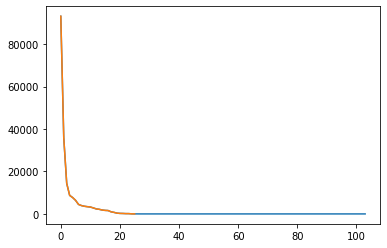

In [65]:
u, s, vt  = np.linalg.svd(arr)
print(s.shape)
plt.plot(range(len(s)),s)

# The first 28 values are the only ones that aren't tiny numbers -- effective rank of 28?

plt.plot(range(27),s[:27])

print(s[:28])

### Randomly hide some of the dates/schools

In [70]:
def known(matrix):
    # returns a list of tuples with indices for known entries in the matrix
    
    indices = []
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] != 0:
                indices.append((i,j))
                
    return indices 

In [73]:
def hide_date(matrix, percent):
    # returns a copy of the original matrix with x percent of the dates hidden
    num_hide = int(len(matrix[0])*percent)

    date_ind = range(len(matrix[0]))
    to_hide = random.sample(date_ind, num_hide)
    to_hide.sort(reverse = True)
    
    for s in matrix:
        for t in to_hide:
            s.pop(t)
    
    return matrix

def hide_school(matrix, percent):
    # returns a copy of the original matrix with x percent of the schools hidden
    num_hide = int(len(matrix)*percent)
    
    school_ind = range(len(matrix))
    to_hide = random.sample(school_ind, num_hide)
    to_hide.sort(reverse = True)
    
    for t in to_hide:
        matrix.pop(t)
    
    return matrix

def hide_entries(matrix, percent):
    # Hides a percent of the known entries in matrix
    # returns a new hidden matrix and a dictionary for indexes and values
    # of the entries that were hidden
    
    knowns = known(matrix)
    num_hide = int(len(knowns)*percent)
    to_hide = random.sample(knowns, num_hide)
    
    hiders = {}
    for t in to_hide:
        hiders[t] = matrix[t[0]][t[1]]
        matrix[t[0]][t[1]] = 0
        
    return matrix, hiders

In [74]:
# Create a copy of the original for comparison later
original = copy.deepcopy(arr)

#arr = hide_date(arr, 0.5)
#arr = hide_school(arr, 0.2)
arr, hide_dict = hide_entries(arr, 0.1)

In [75]:
hide_dict

{(777, 73): 1068,
 (733, 3): 2,
 (719, 73): 45,
 (1790, 73): 48,
 (3, 24): 351,
 (714, 31): 41,
 (1047, 95): 168,
 (502, 18): 190,
 (346, 59): 3,
 (1274, 95): 120,
 (875, 0): 1,
 (3, 20): 321,
 (6, 11): 116,
 (1673, 95): 7,
 (1289, 59): 112,
 (468, 0): 8,
 (694, 95): 210,
 (1, 9): 2330,
 (397, 3): 22,
 (1487, 73): 56,
 (853, 95): 5,
 (683, 73): 101,
 (1104, 59): 8,
 (1102, 95): 614,
 (1189, 73): 40,
 (1076, 59): 153,
 (367, 31): 102,
 (191, 95): 8,
 (1321, 31): 29,
 (452, 0): 10,
 (1347, 46): 105,
 (1, 45): 3117,
 (1442, 73): 3,
 (92, 3): 40,
 (1765, 73): 43,
 (575, 59): 51,
 (52, 46): 93,
 (1361, 46): 3,
 (592, 31): 34,
 (958, 18): 33,
 (1704, 95): 5,
 (60, 46): 17,
 (390, 0): 2,
 (509, 73): 93,
 (634, 31): 14,
 (621, 59): 398,
 (1020, 0): 2,
 (805, 59): 59,
 (340, 95): 107,
 (898, 18): 45,
 (794, 59): 47,
 (171, 3): 13,
 (1337, 95): 66,
 (883, 59): 171,
 (1760, 73): 1,
 (849, 31): 17,
 (592, 59): 79,
 (1098, 18): 27,
 (104, 46): 396,
 (3, 7): 186,
 (1109, 95): 35,
 (966, 73): 54,
 (6

In [76]:
arr[777][73]

0

### Test if the matrix is row increasing 

In [10]:
def is_inc(matrix, printy=True):
    # matrix is a 2d array
    # matrix[0] is the first school
    # NOTE: That is the transpose of what I'm using elsewhere
    #       just to make things easier
    
    non_inc = {}
    for i in range(len(matrix)):
        last = matrix[i][0]
        spots = []
        for j in range(len(matrix[0])):
            if matrix[i][j] != 0 and not np.isnan(matrix[i][j]):
                if matrix[i][j] < last:
                    spots.append(j)
                last = matrix[i][j]
        
        if len(spots) != 0:
            non_inc[i] = spots
        
    if printy == True:
        print(str(len(non_inc)) + " schools are non increasing in at least one spot")
    return non_inc

In [11]:
is_inc(arr)
print('rank ' + str(np.linalg.matrix_rank(arr)))


111 schools are non increasing in at least one spot
rank 27


### Run through lmafit

In [13]:
# make the arrays needed for lmafit

known_seq = [[],[]]
known_values = []
for i in range(len(arr)):
    for j in range(len(arr[0])):
        if arr[i][j] != 0:
            known_seq[0].append(i)
            known_seq[1].append(j)
            known_values.append(arr[i][j])

known_indices = [tuple(known_seq[0]), tuple(known_seq[1])]
known_values = [tuple(known_values)]

In [14]:
X,Y,out = lmafit_mc_adp(len(arr),len(arr[0]),14,known_indices,known_values)

complete = np.dot(X,Y)
print(pd.DataFrame(complete).T)

C:\Users\kq146\code\covid_college_tracker\Covid_data\analysis\lmafit.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Z[Known] = data


            0            1            2           3            4     \
0    1844.595816  2017.102986  1747.454262  119.546657  1358.482279   
1    1879.728502  2022.475889  1765.591461  146.209116  1345.730572   
2    1916.699955  2020.280080  1835.588288  158.263416  1350.298624   
3    1970.901225  2018.855466  1817.408340  191.868772  1335.430508   
4    1962.024323  2020.842248  1873.565576  170.309214  1348.981757   
..           ...          ...          ...         ...          ...   
99   4501.771391   -15.481750  3125.444923  846.626421  3709.903069   
100  4511.105890   175.343858  1606.545870  849.575504  3709.226833   
101  4517.219347   -16.651707    54.282956  869.577418  3710.034191   
102  4525.153676   -90.571138  -266.323134  873.625581  3710.689462   
103  -371.872350   547.919360   975.521335  888.323168  3709.096528   

           5           6            7            8            9     ...  \
0    133.826802   76.234460  1892.237103  1054.397118   641.814006  ... 

### Test for row increasing and do isotonic regression if not

In [15]:
non_inc = is_inc(complete)

1872 schools are non increasing in at least one spot


In [16]:
k = is_inc(arr)

111 schools are non increasing in at least one spot


In [17]:
def iso(matrix):
    # performs isotonic regression for every school
    tonic = copy.deepcopy(matrix) # returns a new isotonic matrix
    
    # dat dict tells me where things arent increasing
    dat_dict = is_inc(matrix, False)
    
    for i in dat_dict.keys():
        to_predict = dat_dict[i]
        leng = len(tonic[0]) - len(to_predict)
        initial_vals = list(tonic[i].copy())
        X = list(range(len(tonic[i])))

        # Use the increasing values to fit the model and then predict what the decreasing ones should be 
        iso = IsotonicRegression().fit(X,initial_vals)
        predictions = iso.predict(range(len(tonic[i])))
        
        # put everything back:
        tonic[i] = predictions
    
    return(tonic)

In [18]:
iso_result = iso(complete)

In [19]:
is_inc(iso_result)

0 schools are non increasing in at least one spot


{}

In [20]:
fin = pd.DataFrame(iso_result)
fin.index = incomplete_matr.columns
print(fin.T)

        Illinois      Indiana         Iowa    Maryland  Michigan State  \
0    1844.595816  2017.102986  1747.454262  119.546657     1347.485496   
1    1879.728502  2020.235388  1765.591461  146.209116     1347.485496   
2    1916.699955  2020.235388  1826.498314  158.263416     1347.485496   
3    1966.462774  2020.235388  1826.498314  180.336290     1347.485496   
4    1966.462774  2020.235388  1868.594843  180.336290     1348.981757   
..           ...          ...          ...         ...             ...   
99   4169.291116  3471.027930  2736.099115  846.626421     3709.619920   
100  4169.291116  3471.027930  2736.099115  849.575504     3709.619920   
101  4169.291116  3471.027930  2736.099115  869.577418     3709.940060   
102  4169.291116  3471.027930  2736.099115  873.625581     3709.940060   
103  4169.291116  3471.027930  2736.099115  888.323168     3709.940060   

      Minnesota  Northwestern   Ohio State   Penn State   UW-Madison  ...  \
0    129.463716     76.234460  189